# Исследование данных сервиса аренды самокатов GoFast

**Цель исследования**
    
    1. Определить выгодны ли сервису пользователи с подпиской или без подписки
    2. Определить целевую аудиторию сервиса
    3. Описать и визуализировать общую информацию о пользователях и поездках
    
    

**Ход исследования**

Извлеку данные из 3 файлов, проверю данные оттуда на вбросы, ошибки и дубликаты. Приведу данные к необходимому для анализа виду. Построю гистограммы по длительности и дальности поездок для пользователей с подпиской и без, посмотрим какого возраста пользователи сервиса и проведем несколько тестов для проверки гипотез о  выгоде подписок.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

#### Загрузка данных

In [5]:
users=pd.read_csv('C:\\Users\\Huawei\\Desktop\\users_go.csv')
rides=pd.read_csv('C:\\Users\\Huawei\\Desktop\\rides_go.csv')
subs=pd.read_csv('C:\\Users\\Huawei\\Desktop\\subscriptions_go.csv')

In [6]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
subs.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [11]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**ВЫВОД:** Получили 3 датафрейма, которые можно объединить. Первые два по ключу user_id, а с 3 по subscription_type. В первом датафрейме содержится основная информация о пользователях, во втором о каждой их поездке, а в 3 информация о типах подписок и тарифах.</div>

#### Предобработка данных

Приведем столбец date к нужному типу pandas, создадим столбец month и проверим результат. 

In [12]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Посмотрим какие есть пропущенные значения

In [13]:
users.isna().sum().sort_values()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
rides.isna().sum().sort_values()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
subs.isna().sum().sort_values()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

И проверим дубликаты

In [16]:
users.duplicated().sum()

31

In [17]:
rides.duplicated().sum()

0

In [18]:
subs.duplicated().sum()

0

Удалим явные дубликаты из таблицы users и проверим результат.

In [19]:
users=users.drop_duplicates()
users.duplicated().sum()

0

**Вывод**: В данных было обнаружено 31 явных дубликатов, от которых было просто избавиться.Пропущенных значений не было. Значит можно дальше работать с данными без потерии качества анализа.

#### Исследовательский анализ данных

##### Частота встречаемости городов

In [20]:
sorted(users['city'].unique())

['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

In [21]:
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

<Axes: title={'center': 'Частота встречаемости городов среди пользователей сервиса GoFast'}, xlabel='Город', ylabel='Количество пользоавтелей'>

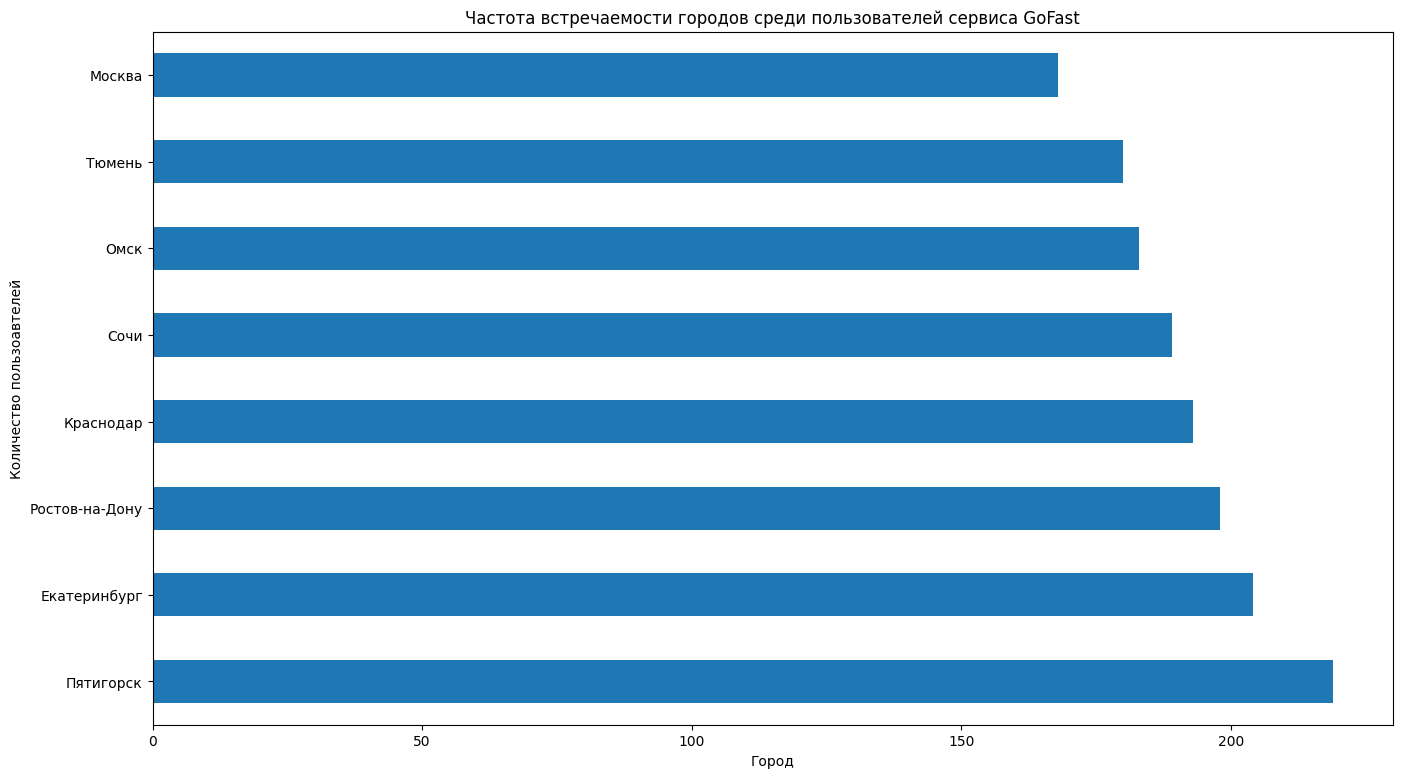

In [22]:
users['city'].value_counts().plot(kind='barh', figsize=(16,9), xlabel='Город', ylabel='Количество пользоавтелей', title='Частота встречаемости городов среди пользователей сервиса GoFast')

**ВЫВОД:** Таким образом, мы видим, что сервисом пользуются в 8 городах. И наибольшее количество пользователей в Пятигорске, в то время как наименшее в Москве.

##### Соотношение пользователей с подпиской и без подписки;

Посмотрим общее количество пользователей с подпиской и без

In [23]:
users['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

In [24]:
users.subscription_type.value_counts(normalize=True).mul(100).round(1)

subscription_type
free     54.4
ultra    45.6
Name: proportion, dtype: float64

<Axes: title={'center': 'Пользователи с подпиской и без'}, ylabel='count'>

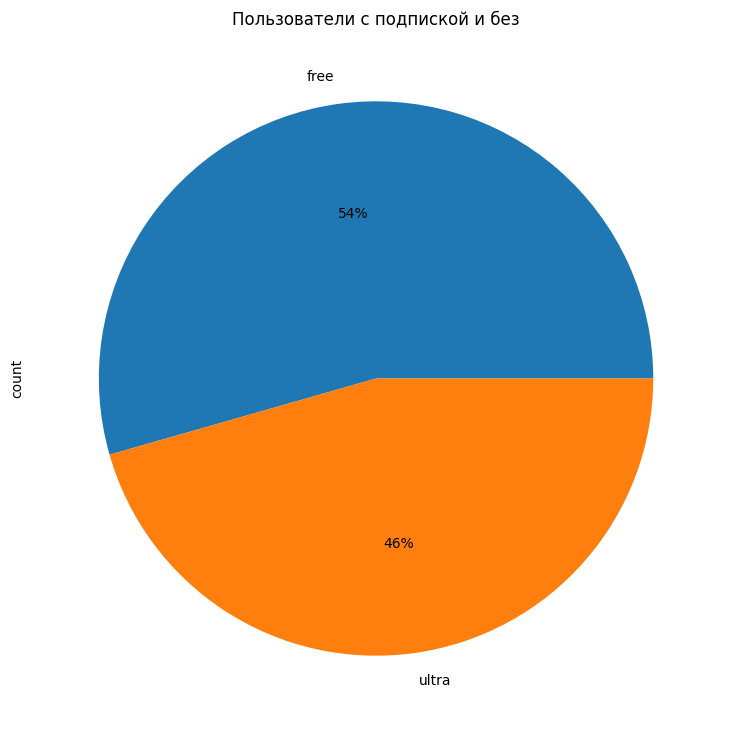

In [25]:
users['subscription_type'].value_counts().plot(kind='pie', figsize=(16,9), autopct='%1.0f%%', title='Пользователи с подпиской и без')

**ВЫВОД:** Как мы видим большинство людей пользуются сервисом без подписки, хотя разница и не совсем большая.

##### Возраст пользователей

Выведем все возрасты пользователей, процентное соотношение к общему кол-ву пользователей и средний возраст пользователя.

In [26]:
users['age'].value_counts()

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64

In [27]:
users.age.value_counts(normalize=True).mul(100).round(1).astype(str)

age
25    9.5
24    8.6
26    8.5
23    8.4
22    7.8
27    7.8
28    7.3
21    6.1
20    4.6
30    4.4
29    4.4
31    3.1
19    3.1
18    3.0
32    2.7
33    2.5
17    1.7
16    1.2
34    1.2
35    1.0
15    0.8
14    0.6
13    0.5
36    0.4
12    0.3
38    0.2
37    0.1
39    0.1
43    0.1
Name: proportion, dtype: object

In [28]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Возраста пользователей')

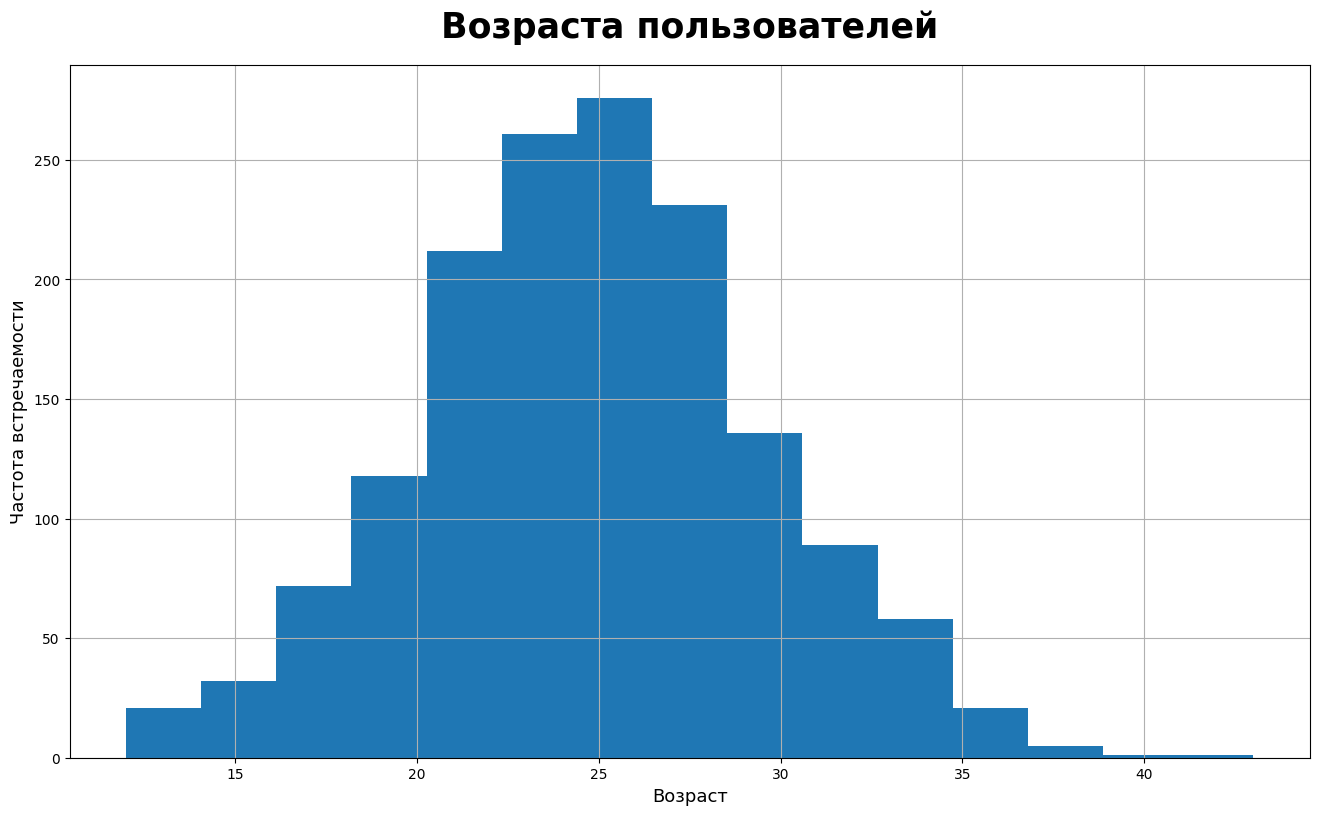

In [29]:
users['age'].hist(bins=15, figsize=(16,9))
plt.xlabel("Возраст", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Возраста пользователей',fontsize=25,fontweight='bold', pad=20)

**ОПИСАНИЕ:** Результат похож на нормальное распределение. Возрасты пользователей лежат в диапозоне от 12 до 43 лет. Средний возраст пользовател 25 лет. Аномалий обнаружено не было.

##### Расстояние, которое пользователь преодолел за одну поездку

Text(0.5, 1.0, 'Расстояние за одну поездку')

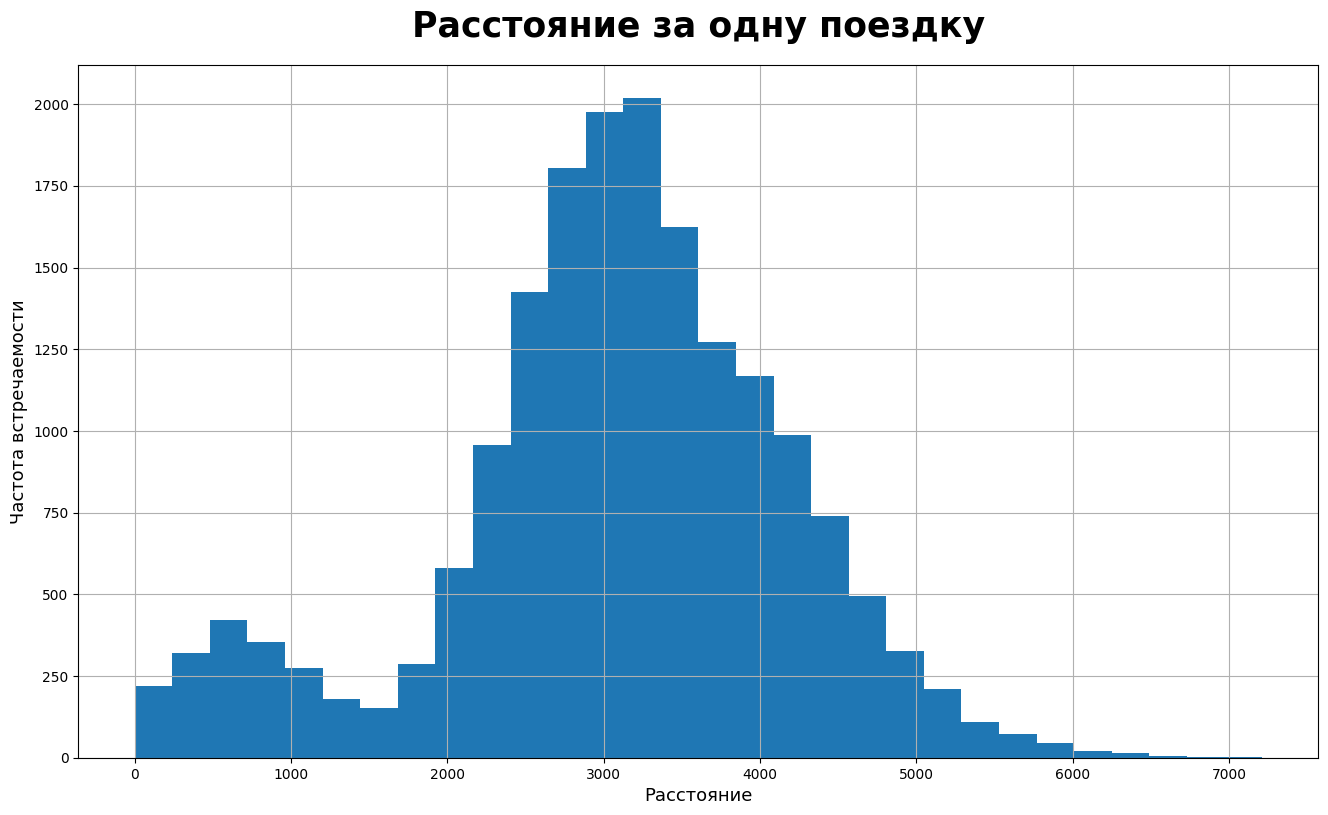

In [30]:
rides['distance'].hist(bins = 30, grid=True, figsize=(16,9))
plt.xlabel("Расстояние", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Расстояние за одну поездку',fontsize=25,fontweight='bold', pad=20)

In [31]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Вывод:** Мы видим, что средняя продолжительность поездки составляет от 2543 м до 3776 м.

##### Продолжительность поездок


Text(0.5, 1.0, 'Продолжительность поездок')

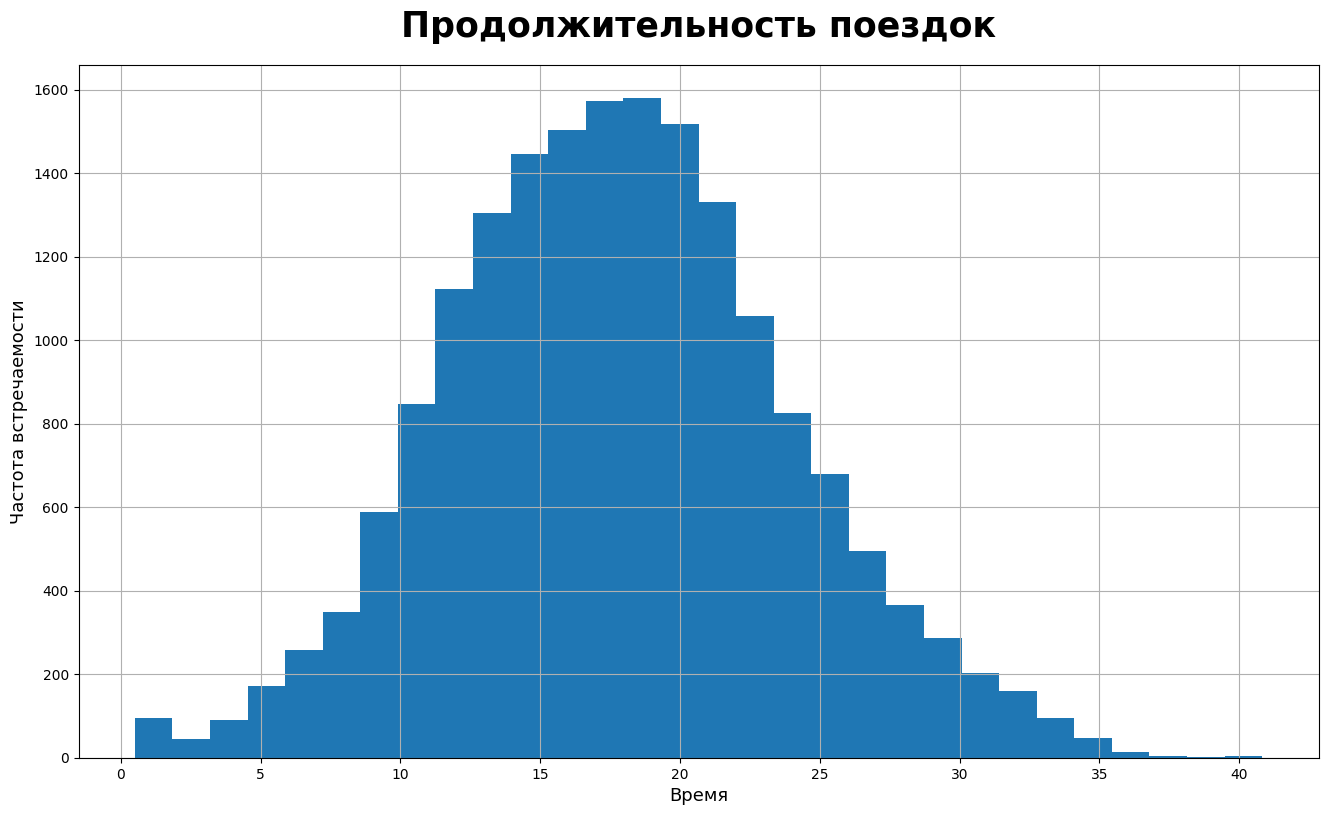

In [32]:
rides['duration'].hist(bins=30, figsize=(16,9))
plt.xlabel("Время", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Продолжительность поездок',fontsize=25,fontweight='bold', pad=20)

In [33]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Вывод:** Cредняя продолжительность поездки составляет от 13,6 до 21,7 минут. 

#### Объединение данных

Проверим размеры датасетов до объединения.

In [34]:
users.info()
rides.info()
subs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB
<class '

In [35]:
df=users.merge(subs, on='subscription_type', how='left')
df=df.merge(rides, on='user_id', how='left')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   minute_price       18068 non-null  int64         
 6   start_ride_price   18068 non-null  int64         
 7   subscription_fee   18068 non-null  int64         
 8   distance           18068 non-null  float64       
 9   duration           18068 non-null  float64       
 10  date               18068 non-null  datetime64[ns]
 11  month              18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Увидели, что после объединения у нас 13 столбцов и 18068 сторк.

Создадим датафреймы пользователей без подписки и с подпиской

In [37]:
df_free = df[df['subscription_type']=='free']

In [38]:
df_free.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2


In [39]:
df_ultra = df[df['subscription_type']=='ultra']

In [40]:
df_ultra.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


Расстояние и время поездки для пользователей без подпиской

Text(0.5, 1.0, 'Расстояние для пользователя без подписки')

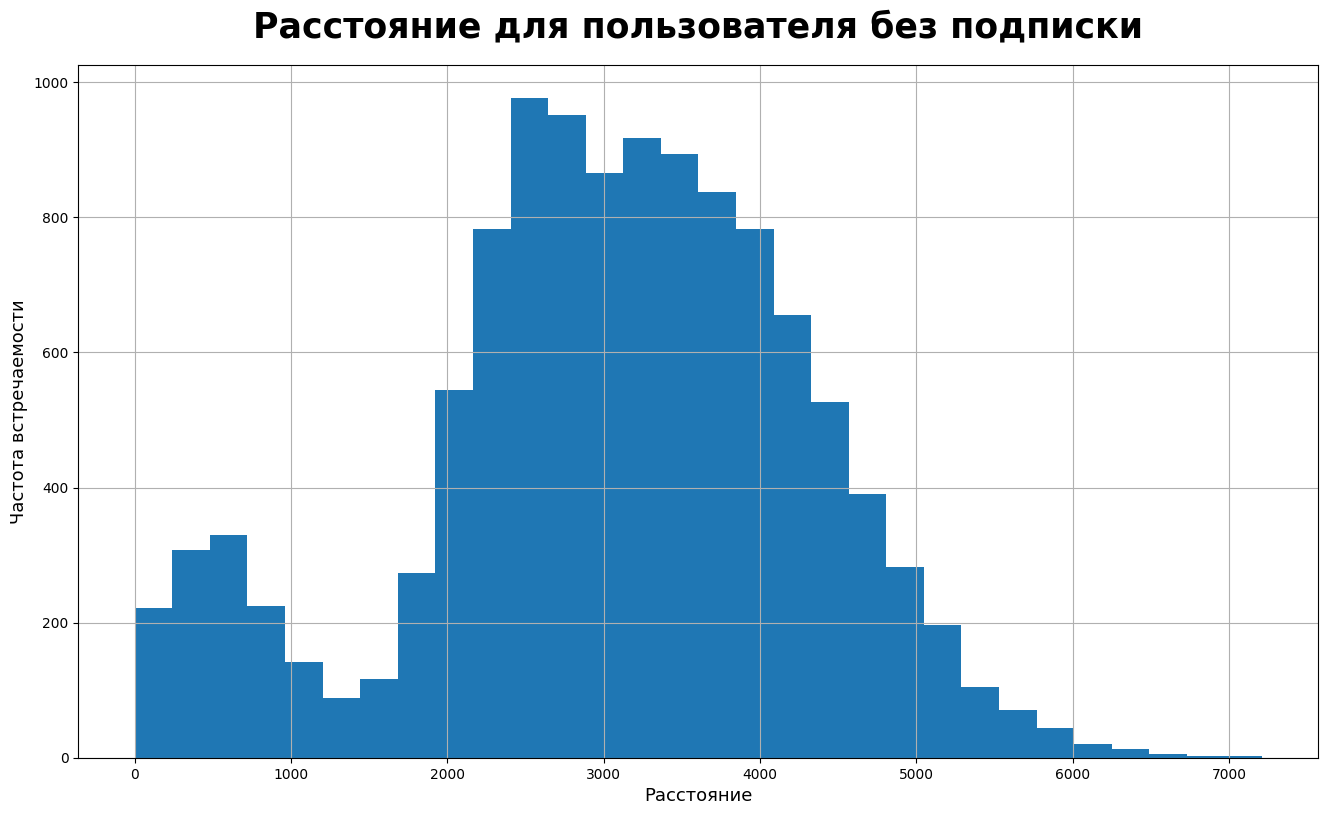

In [41]:
df_free['distance'].hist(bins = 30, grid=True, figsize=(16,9))
plt.xlabel("Расстояние", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Расстояние для пользователя без подписки',fontsize=25,fontweight='bold', pad=20)

Text(0.5, 1.0, 'Продолжительность для пользователя без подписки')

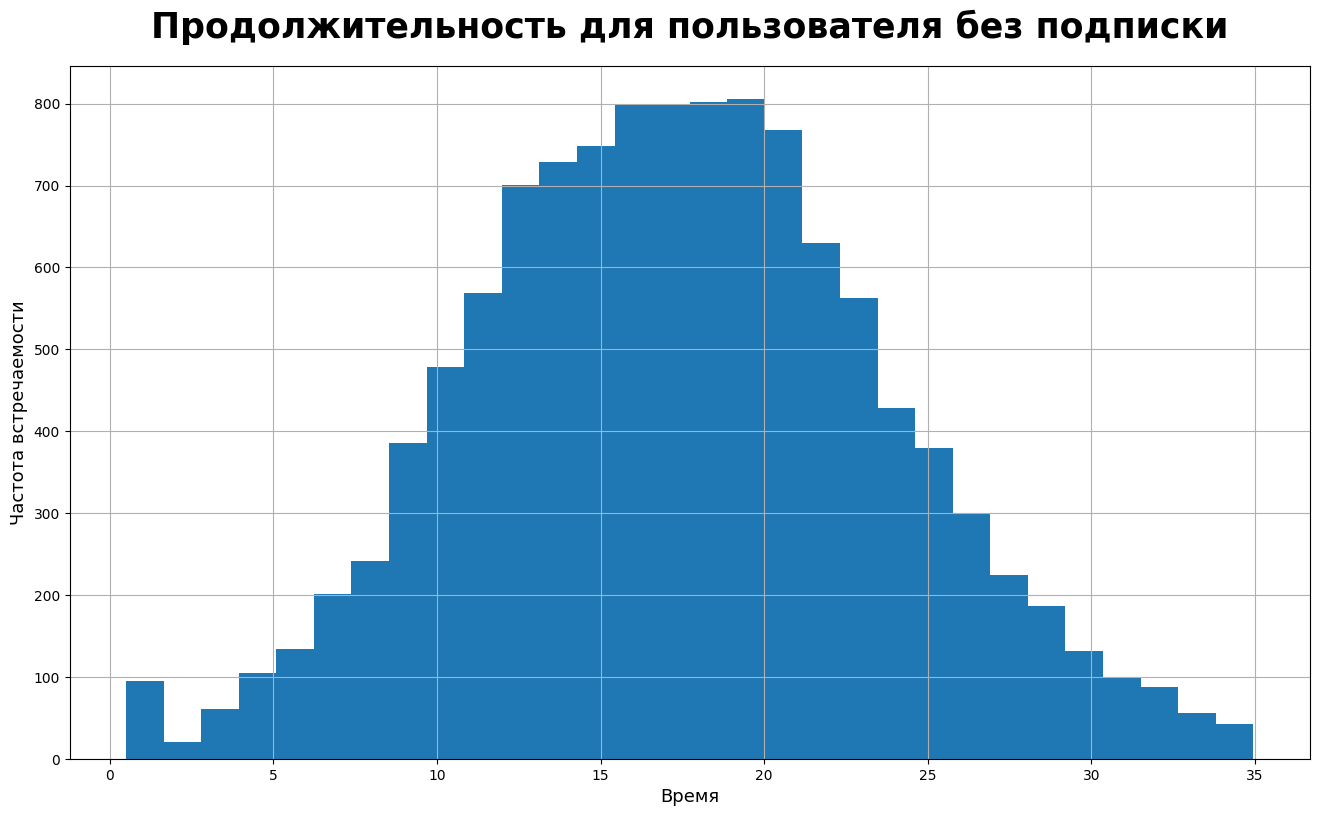

In [42]:
df_free['duration'].hist(bins = 30, grid=True, figsize=(16,9))
plt.xlabel("Время", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Продолжительность для пользователя без подписки',fontsize=25,fontweight='bold', pad=20)

Теперь визуализируем расстояние и время поездки для пользователей с подпиской

Text(0.5, 1.0, 'Расстояние для пользователя с подпиской')

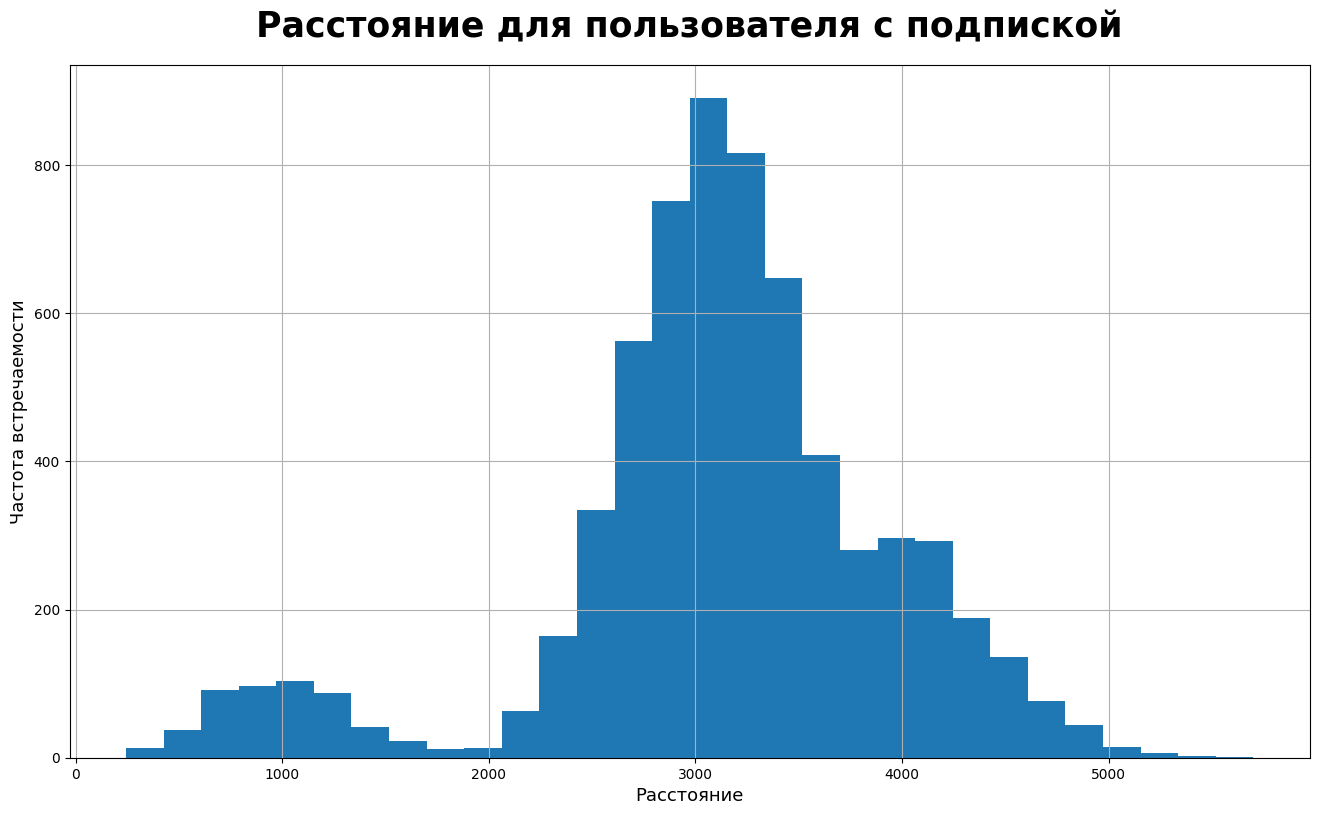

In [43]:
df_ultra['distance'].hist(bins = 30, grid=True, figsize=(16,9))
plt.xlabel("Расстояние", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Расстояние для пользователя с подпиской',fontsize=25,fontweight='bold', pad=20)

Text(0.5, 1.0, 'Продолжительность для пользователя с подпиской')

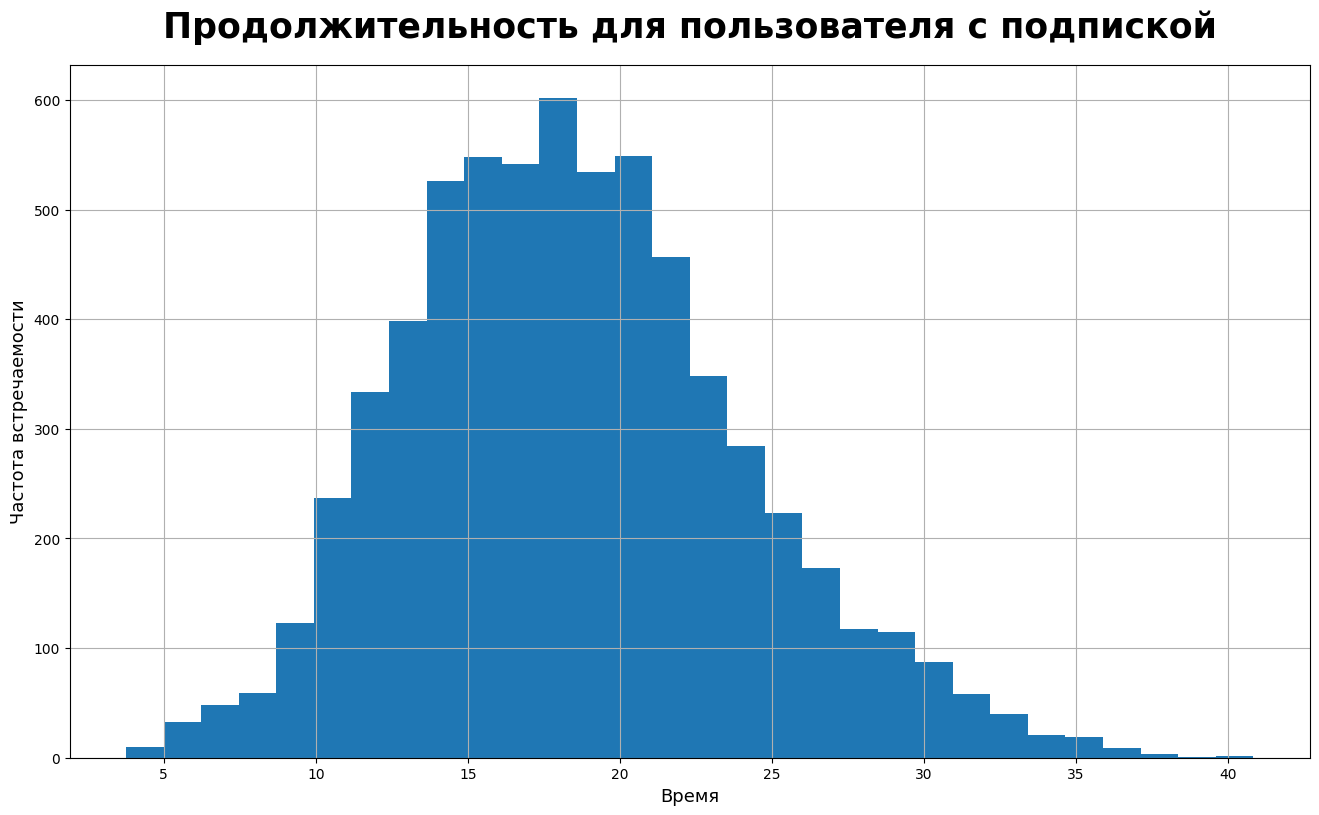

In [44]:
df_ultra['duration'].hist(bins = 30, grid=True, figsize=(16,9))
plt.xlabel("Время", fontsize=13)
plt.ylabel("Частота встречаемости", fontsize=13)
plt.title('Продолжительность для пользователя с подпиской',fontsize=25,fontweight='bold', pad=20)

**ВЫВОД:** По полученным графикам видно, что пользователи с подпиской проезжают большие расстояния. Пик на графике для пользователей с подписко находится правее. По времени наоборот создается впечатление, что пользователи без подписки едут дольше.

#### Подсчёт выручки

In [45]:
df_new=df.groupby(['user_id', 'name', 'month']).agg({'distance':'sum'})

In [46]:
df_new['distance']=np.ceil(df_new['distance'])

In [47]:
df_new.head()

distance
user_id name month          
1       Кира 1        7028.0
             4         755.0
             8        6724.0
             10       5810.0
             11       7004.0

In [48]:
df_new['duration_sum'] = df.groupby(['user_id', 'name', 'month']).agg({'duration':'sum',})
df_new['rides_count'] = df.groupby(['user_id', 'name', 'month']).agg({'duration':'count',})

In [49]:
df_new.head(20)

distance  duration_sum  rides_count
user_id name      month                                     
1       Кира      1        7028.0     41.416640            2
                  4         755.0      6.232113            1
                  8        6724.0     44.776802            2
                  10       5810.0     31.578017            2
                  11       7004.0     53.397424            3
                  12       6752.0     27.203912            2
2       Станислав 3       10188.0     60.959959            3
                  4        6165.0     39.048633            2
                  6        3256.0     13.851127            1
                  7        6781.0     46.170157            2
                  8         924.0      6.914760            1
                  10       2825.0     18.779128            1
                  12       3829.0     11.920514            1
3       Алексей   1        3062.0     12.654443            1
                  2        5422.0     37.568637            2
                  4        2957.0     20.671364            1
                  5        9065.0     61.404503            3
                  7       10920.0     65.519784            3
                  9        2892.0     22.390055            1
                  12       2594.0     12.984728            1

In [50]:
df_new['duration_sum']=np.ceil(df_new['duration_sum'])
df['duration']=np.ceil(df['duration'])

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [51]:
df['cost']=df['start_ride_price']+df['minute_price']*df['duration']

In [52]:
df

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,cost
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,26.0,2021-01-01,1,156.0
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,16.0,2021-01-18,1,96.0
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,7.0,2021-04-20,4,42.0
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,19.0,2021-08-11,8,114.0
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,27.0,2021-08-28,8,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,20.0,2021-11-04,11,210.0
18064,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,22.0,2021-11-16,11,226.0
18065,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,19.0,2021-11-18,11,202.0
18066,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,17.0,2021-11-27,11,186.0


In [53]:
df_new['cost']=df.groupby(['user_id', 'name', 'month']).agg({'cost':'sum',})
df_new['subscription'] = df.groupby(['user_id', 'name', 'month']).agg({'subscription_fee':'max'})

In [54]:
df_new

distance  duration_sum  rides_count   cost  \
user_id name    month                                               
1       Кира    1        7028.0          42.0            2  252.0   
                4         755.0           7.0            1   42.0   
                8        6724.0          45.0            2  276.0   
                10       5810.0          32.0            2  192.0   
                11       7004.0          54.0            3  336.0   
...                         ...           ...          ...    ...   
1534    Альберт 6        3410.0          25.0            2  308.0   
                8        7623.0          48.0            2  484.0   
                9        4929.0          23.0            1  234.0   
                11      13351.0          77.0            4  824.0   
                12       2372.0          16.0            1  178.0   

                       subscription  
user_id name    month                
1       Кира    1               199  
                4               199  
                8               199  
                10              199  
                11              199  
...                             ...  
1534    Альберт 6                 0  
                8                 0  
                9                 0  
                11                0  
                12                0  

[11331 rows x 5 columns]

Теперь отдельно добавим к общей стоимости подписку.

In [55]:
df_new['cost']=df_new['cost']+df_new['subscription']

In [56]:
df_new

distance  duration_sum  rides_count   cost  \
user_id name    month                                               
1       Кира    1        7028.0          42.0            2  451.0   
                4         755.0           7.0            1  241.0   
                8        6724.0          45.0            2  475.0   
                10       5810.0          32.0            2  391.0   
                11       7004.0          54.0            3  535.0   
...                         ...           ...          ...    ...   
1534    Альберт 6        3410.0          25.0            2  308.0   
                8        7623.0          48.0            2  484.0   
                9        4929.0          23.0            1  234.0   
                11      13351.0          77.0            4  824.0   
                12       2372.0          16.0            1  178.0   

                       subscription  
user_id name    month                
1       Кира    1               199  
                4               199  
                8               199  
                10              199  
                11              199  
...                             ...  
1534    Альберт 6                 0  
                8                 0  
                9                 0  
                11                0  
                12                0  

[11331 rows x 5 columns]

#### Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

Сформулируем нулевую и альтернативную гипотезы.

$H_{0}$ -  среднее время поездки пользователя с подпиской равна общему среднему значению

$H_{1}$ - среднее время поездки пользователя с подпиской больше общего среднего значения

Установим статистическую значимость равно 0.05

In [57]:
ultra = df_ultra['duration'] 
free = df_free['duration']

alpha = 0.05

results = st.ttest_ind(ultra, free, alternative = 'greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:    
    print('Отвергаем нулевую гипотезу')
else: 
   print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Получается, что мы отвергаем нулевую гипотезу и, таким образом, делаем вывод, что пользователи с подпиской действительно тратят больше времени на поездку.

##### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает  3130 метров?

Сформулируем нулевую и альтернативную гипотезы.

$H_{0}$ -  среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

$H_{1}$ - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

Установим статистическую значимость равно 0.05

In [58]:
df_ultra

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,6,0,199,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,6,0,199,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,6,0,199,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,6,0,199,4707.845501,15.839579,2021-10-17,10


In [59]:
ultra = df_ultra['distance'] 
target=3130

alpha = 0.05

results = st.ttest_1samp(ultra, target, alternative = 'greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:    
    print('Отвергаем нулевую гипотезу')
else: 
   print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


#####  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Сформулируем нулевую и альтернативную гипотезы.

$H_{0}$ -  помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки

$H_{1}$ - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Установим статистическую значимость равной 0.05

In [60]:
ultra=df_new[df_new['subscription']==199]['cost']
free=df_new[df_new['subscription']==0]['cost']

alpha=0.05

results = st.ttest_ind(ultra, free, alternative = 'greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:    
    print('Отвергаем нулевую гипотезу')
else: 
   print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


##### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Сформулируем нулевую и альтернативную гипотезы.

$H_{0}$ -  среднее количество обращений до обновления равно среднему количеству обращений после обновления

$H_{1}$ - реднее количество обращений до обновления больше среднего количества обращений после обновления

Воспользуемся парным t-тестом scipy.stats.ttest_rel.

#### Вывод

1. Сервисом пользуются в 8 крупных городах. Чуть больше половины пользователей оформили подписку, а 46% пользуются без подписки.

2. Выручка от пользователей с подпиской выше, чем от пользователей без подписки, при этом пользователи с подпиской тратят больше времени на поездку и проезжают расстояния больше 3130 метров.

3. В основном сервисом пользуется молодежь. Средний возраст пользователя 24-25 лет.

**Рекомендации:**
1. Предлагать новым пользователям бесплатную пробную подписку с автопродлением.
    
2. Внедрить реферальные программы, где пользователи могут получать бонусы за привлечение друзей к подписке Ultra.
    
3. Расширить зоны покрытия в 8 крупных городах, особенно в местах с высокой плотностью молодежи, чтобы сделать сервис более доступным.
    
4. Внедрить более дешевую подписку для студентов.